# Exploratory Data Analysis

## Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew
from scipy.fft import rfft, rfftfreq

## Defining Used Functions

In [14]:

def perform_eda_overall(df):
    """
    EDA plots
    """

    vibration_channels = ['Channel 3','Channel 3 Kurtosis', 'Temperature' ,'Humidity' ,'Engine_status']

    print("=== Overall Dataset Information ===")
    print(f"Total rows: {len(df):,}")
    print(f"Unique RPM values: {sorted(df['RPM'].unique())}")
    print(f"Unique Humidity values: {sorted(df['Humidity'].unique())}")
    print(f"Unique Temperature values: {sorted(df['Temperature'].unique())}\n")
    print("--- Data Info ---")
    print(df.info())
    print("\n--- Numerical Summary ---")
    display(df.describe().T)
    print("\n--- Missing Values ---")
    print(df.isnull().sum()[df.isnull().sum() > 0])
    print(f"\nDuplicate Rows: {df.duplicated().sum()}")

    
    # Global RMS per channel
    print("Global RMS per Channel:")
    for ch in vibration_channels:
        rms = df[ch].mean()
        print(f"  {ch}: {rms:.6f}")
    
    # Estimate sampling rate
    time_diff_mean = df['Time'].diff().mean()
    if pd.isna(time_diff_mean) or time_diff_mean == 0:
        sampling_rate = 3200
        print("Warning: Could not compute sampling rate from 'Time'. Using default 10kHz.")
    else:
        sampling_rate = 1 / time_diff_mean
        print(f"Estimated sampling rate: {sampling_rate:.0f} Hz")
    
    plt.style.use('seaborn-v0_8')
    sns.set_palette("deep")

    figsize = (14,7)
    
    # --- 3.1 Target Variable Distribution ---
    plt.figure(figsize=figsize)
    ax = sns.countplot(x='Engine_status', data=df, palette='viridis')
    plt.title('Distribution of Target Variable (Engine_status)')
    plt.ylabel('Counts')

    # Add percentage labels
    total = len(df)
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.1f}%'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='bottom')
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.boxplot(x='Engine_status', y='Channel 3', data=df, palette='Set2', ax=axes[0])
    axes[0].set_title('Engine status Vs Channel 3')
    axes[0].set_xlabel('Engine_status')

    sns.kdeplot(data=df, x='Channel 3', hue='Engine_status', fill=True, palette='Set2', ax=axes[1])
    axes[1].set_title('Chennel 3 Density by Engine status')
    plt.tight_layout()
    plt.show()

    # ====================== PLOT 1 ======================
    plt.figure(figsize=figsize)
    sns.histplot(df['Channel 1'], bins=100, kde=True, stat="density", color='teal')
    plt.title("Channel 1  Overall vibration response on the bearing housing", fontsize=14)
    plt.xlabel("Amplitude")
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()


   # ====================== PLOT 2 ======================
    plt.figure(figsize=figsize)
    sns.histplot(df['Channel 3'], bins=100, kde=True, stat="density", color='teal')
    plt.title("Channel 3  Vibration measured on the bearing housing", fontsize=14)
    plt.xlabel("Amplitude")
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()

    # ====================== PLOT 3 ======================
    plt.figure(figsize=figsize)
    melted_rpm = df.melt(id_vars=['RPM'], value_vars=['Channel 3'],
                         var_name='Channel', value_name='Amplitude')
    sns.boxplot(data=melted_rpm, x='RPM', y='Amplitude', hue='Channel')
    plt.title("Amplitude Distribution by RPM (Channel 3)", fontsize=14)
    plt.yscale('symlog')
    plt.ylabel("Amplitude (symlog scale)")
    plt.legend(title="Channel")
    plt.grid(True)
    plt.show()

    # ====================== PLOT 4 ======================
    plt.figure(figsize=figsize)
    window_size = min(10000, len(df)//10)
    rolling_rms = df['Channel 3'].rolling(window=window_size, center=True).apply(lambda x: np.sqrt(np.mean(x**2)), raw=True)
    df_plot = df.copy()
    df_plot['Rolling_RMS_Ch3'] = rolling_rms
    sns.lineplot(data=df_plot, x='Temperature', y='Rolling_RMS_Ch3', hue='RPM', estimator='mean')
    plt.title(f"Rolling RMS (Channel 3) vs Temperature\n(window size = {window_size})", fontsize=14)
    plt.ylabel("Rolling RMS")
    plt.grid(True)
    plt.show()

    # ====================== PLOT 5 ======================
    plt.figure(figsize=figsize)
    N =  len(df) - 1
    sig = df['Channel 3'].dropna().values[:N]
    fft_mag = np.abs(rfft(sig))
    freqs = rfftfreq(N, 1/sampling_rate)
    plt.plot(freqs[:N//4], fft_mag[:N//4], color='darkblue')
    plt.title("FFT Spectrum - Channel 3 (Overall)", fontsize=14)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.show()

    # ====================== PLOT 6 ======================
    plt.figure(figsize=figsize)
    melted_humidity = df.melt(id_vars=['Humidity'], value_vars=vibration_channels,
                              var_name='Channel', value_name='Amplitude')
    sns.violinplot(data=melted_humidity, x='Humidity', y='Amplitude', hue='Channel')
    plt.title("Amplitude Distribution by Humidity (All Channels)", fontsize=14)
    plt.yscale('symlog')
    plt.ylabel("Amplitude (symlog scale)")
    plt.legend(title="Channel")
    plt.grid(True)
    plt.show()

    # ====================== PLOT 7 ======================
    plt.figure(figsize=figsize)
    sample_df = df.sample(min(10000, len(df)), random_state=42)
    sns.scatterplot(data=sample_df, x='Temperature', y='Channel 3',
                    hue='RPM', style='Humidity', alpha=0.7, s=50)
    plt.title("Channel 3 Amplitude vs Temperature (10k samples)", fontsize=14)
    plt.grid(True)
    plt.show()

    # ====================== PLOT 8 ======================
    plt.figure(figsize=(10, 8))
    corr = df[vibration_channels].corr()
    sns.heatmap(corr, annot=True, fmt=".3f", cmap="coolwarm", center=0, square=True)
    plt.title("Correlation Between Vibration Channels", fontsize=14)
    plt.show()

    # ====================== PLOT 9 ======================
    plt.figure(figsize=(10, 6))
    provided_mean = df['Channel 3 Kurtosis'].mean()
    computed_kurt = kurtosis(df['Channel 3'].dropna(), fisher=False)
    plt.bar(['Provided (mean)', 'Computed (overall)'],
            [provided_mean, computed_kurt], color=['steelblue', 'orange'], width=0.6)
    plt.title("Channel 3 Kurtosis: Provided vs Computed", fontsize=14)
    plt.ylabel("Kurtosis Value")
    plt.grid(True, axis='y')
    plt.show()

    # ====================== PLOT 11 ======================
    plt.figure(figsize=figsize)
    sns.boxenplot(data=df, x='Temperature', y='Channel 3')
    plt.title("Channel 3 Amplitude Distribution by Temperature", fontsize=14)
    plt.yscale('symlog')
    plt.ylabel("Amplitude (symlog scale)")
    plt.grid(True)
    plt.show()

    # ====================== PLOT 12 ======================
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=df, x='Time', y='Channel 3', hue='RPM', alpha=0.7)
    plt.title("Channel 3 Time Series (first 50,000 points)", fontsize=14)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(14, 6))
    sns.pairplot(df[vibration_channels], hue="Engine_Condition", diag_kind="kde")
    plt.show()

    print("\nAll plots have been displayed individually!")


## Loading the Data Set

In [3]:
Enging_df = pd.read_csv("data/Engine Journal Bearings Dataset/Engine_Bearings_Dataset.csv")


=== Overall Dataset Information ===
Total rows: 390,263
Unique RPM values: [np.int64(1000), np.int64(1500), np.int64(2000)]
Unique Humidity values: [np.int64(0), np.int64(50), np.int64(100)]
Unique Temperature values: [np.int64(-10), np.int64(0), np.int64(15), np.int64(30), np.int64(45)]

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390263 entries, 0 to 390262
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          390263 non-null  int64  
 1   Time                390263 non-null  float64
 2   Demand 1            390263 non-null  float64
 3   Control 1           390263 non-null  float64
 4   Output Drive 1      390263 non-null  float64
 5   Channel 1           390263 non-null  float64
 6   Channel 2           390263 non-null  float64
 7   Channel 3           390263 non-null  float64
 8   Channel 4           390263 non-null  float64
 9   Channel 1 Kurtosis  390263

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,390263.0,1.951310e+05,1.126594e+05,0.000000e+00,9.756550e+04,1.951310e+05,2.926965e+05,3.902620e+05
Time,390263.0,9.594773e+00,7.687462e+00,6.333330e-04,3.034680e+00,7.813680e+00,1.469880e+01,3.322360e+01
Demand 1,390263.0,4.605732e-01,1.101767e-01,1.250110e-01,5.000440e-01,5.000440e-01,5.000440e-01,5.000440e-01
Control 1,390263.0,4.758429e-01,1.039170e-01,5.860880e-02,5.011020e-01,5.130120e-01,5.208540e-01,6.462960e-01
Output Drive 1,390263.0,3.218047e-02,1.025123e-02,0.000000e+00,3.270980e-02,3.516840e-02,3.664420e-02,5.000260e-02
Channel 1,390263.0,4.851646e-01,1.087692e-01,5.161400e-02,5.002270e-01,5.138600e-01,5.300705e-01,7.507820e-01
Channel 2,390263.0,5.175571e-01,1.094092e-01,9.107770e-02,5.407860e-01,5.522980e-01,5.674960e-01,8.076860e-01
Channel 3,390263.0,1.685951e+00,1.573012e+00,9.768130e-02,1.202145e+00,1.294640e+00,1.526540e+00,1.575500e+01
Channel 4,390263.0,1.730440e-15,3.655549e-17,1.225050e-15,1.719810e-15,1.737500e-15,1.746180e-15,2.078580e-15
Channel 1 Kurtosis,390263.0,3.033824e+00,1.195905e-01,1.878400e+00,3.013520e+00,3.043360e+00,3.072000e+00,1.007590e+01



--- Missing Values ---
Series([], dtype: int64)

Duplicate Rows: 0
Global RMS per Channel:
  Channel 3: 1.685951
  Channel 3 Kurtosis: 4.413186
  Temperature: 15.397386
  Humidity: 49.783223
  Engine_status: 0.537233
Estimated sampling rate: 226956 Hz


/tmp/ipykernel_25860/4140970020.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Engine_status', data=df, palette='viridis')


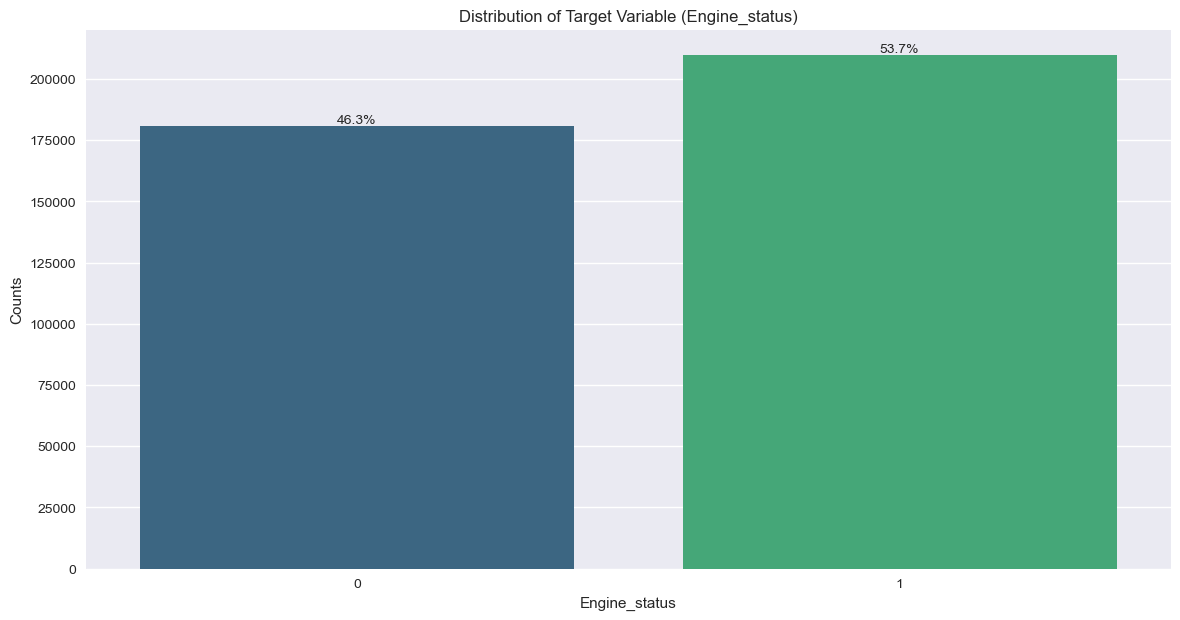

/tmp/ipykernel_25860/4140970020.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Engine_status', y='Channel 3', data=df, palette='Set2', ax=axes[0])


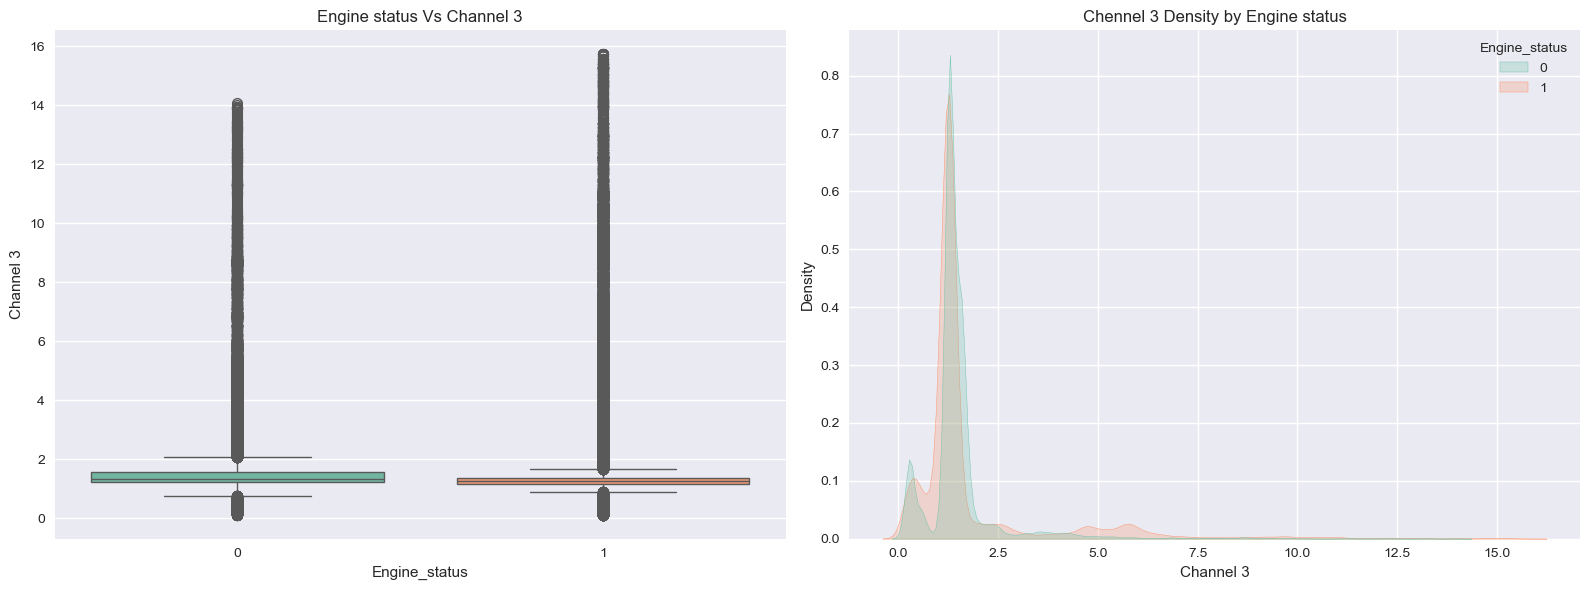

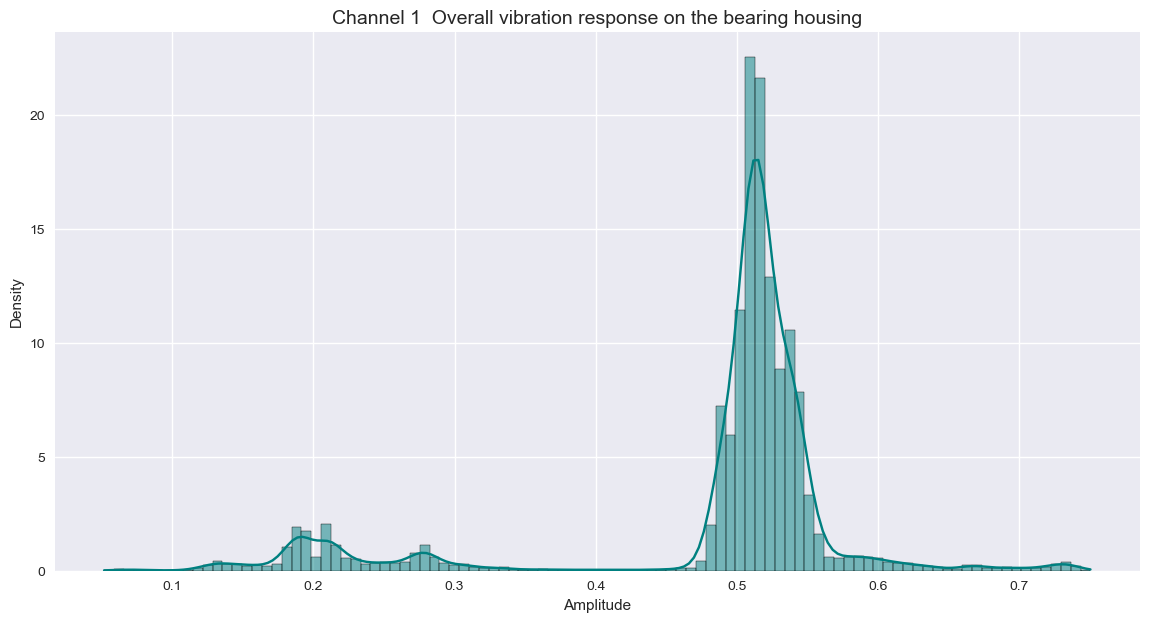

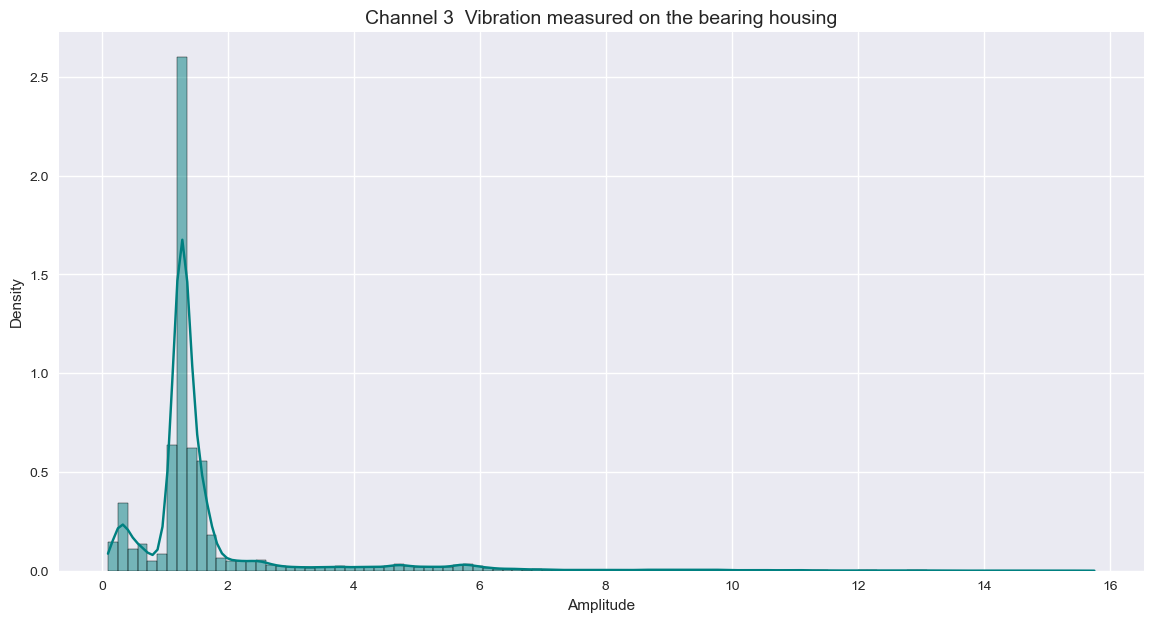

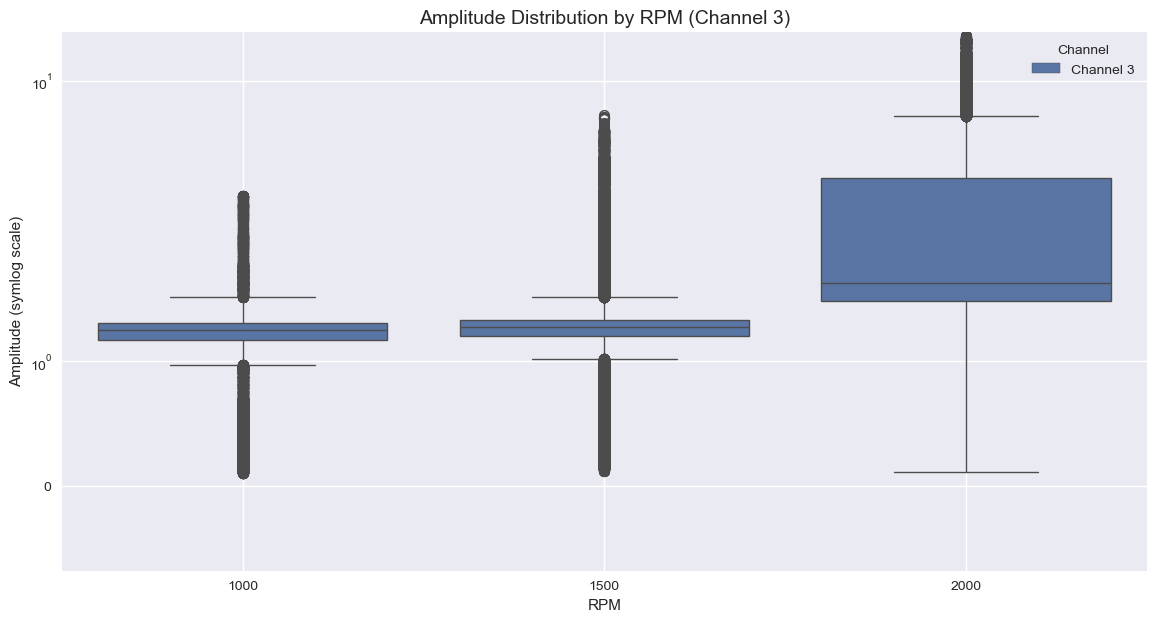

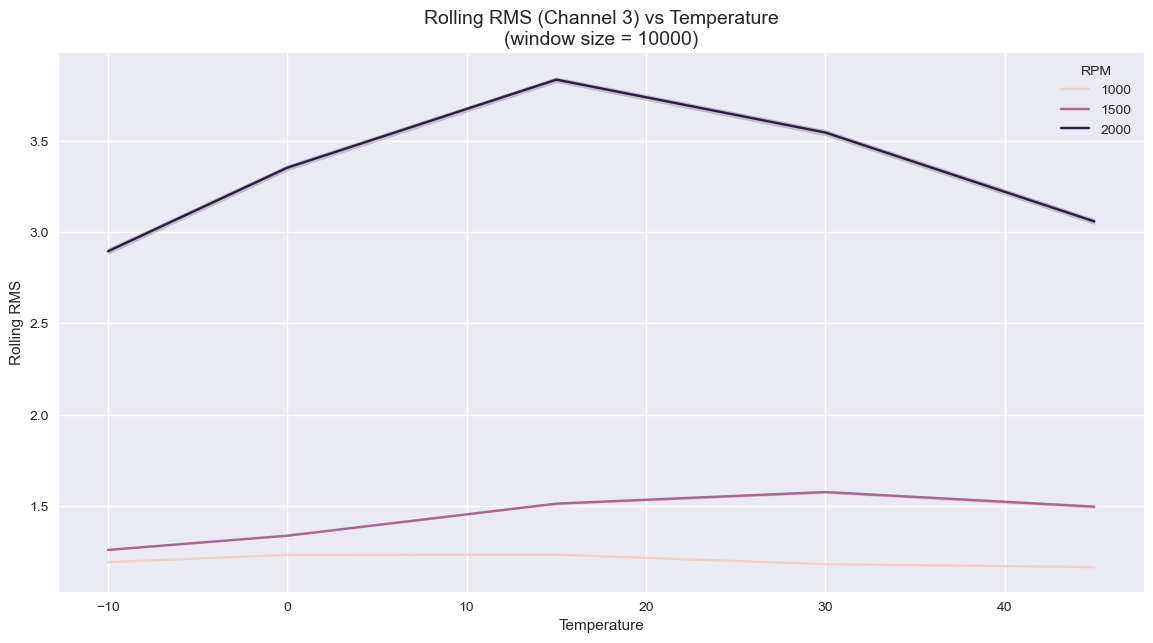

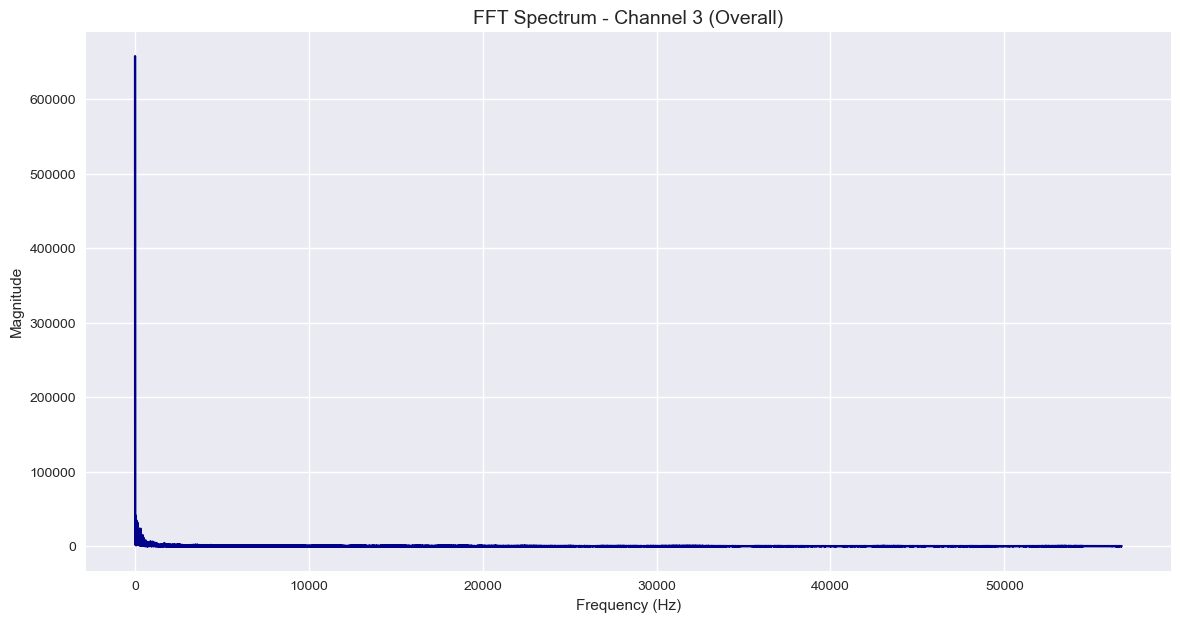

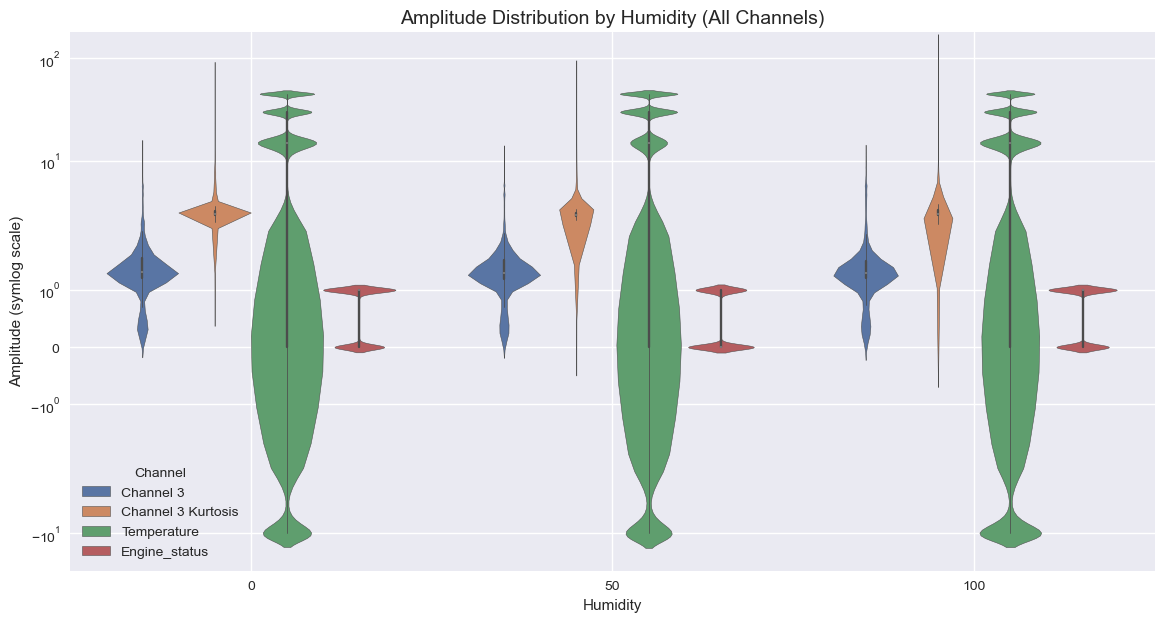

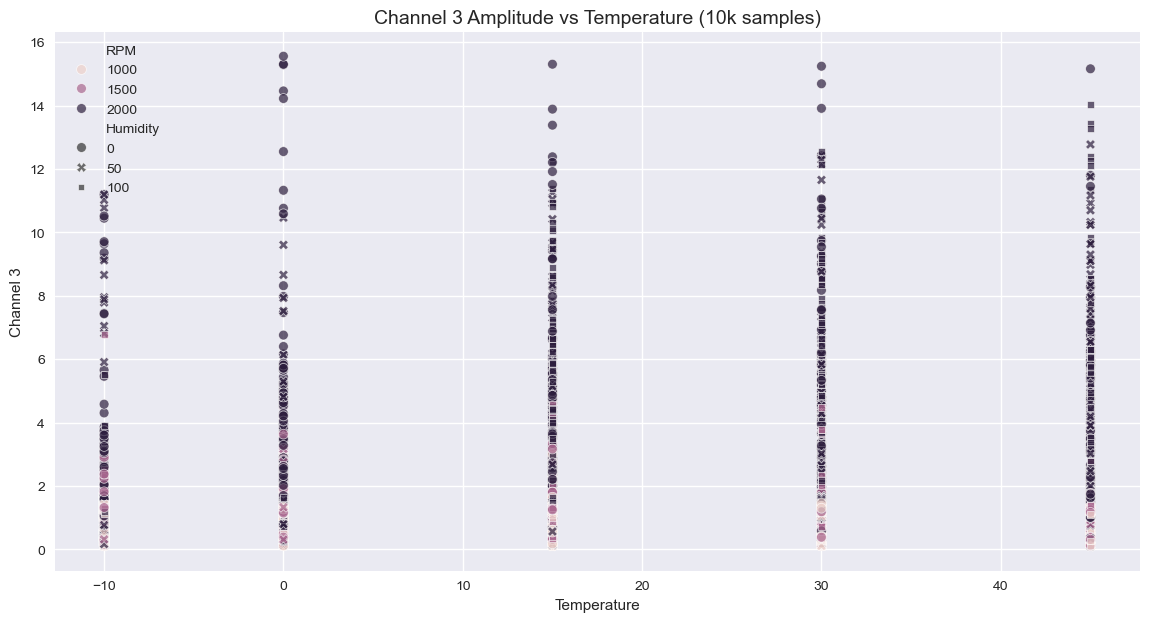

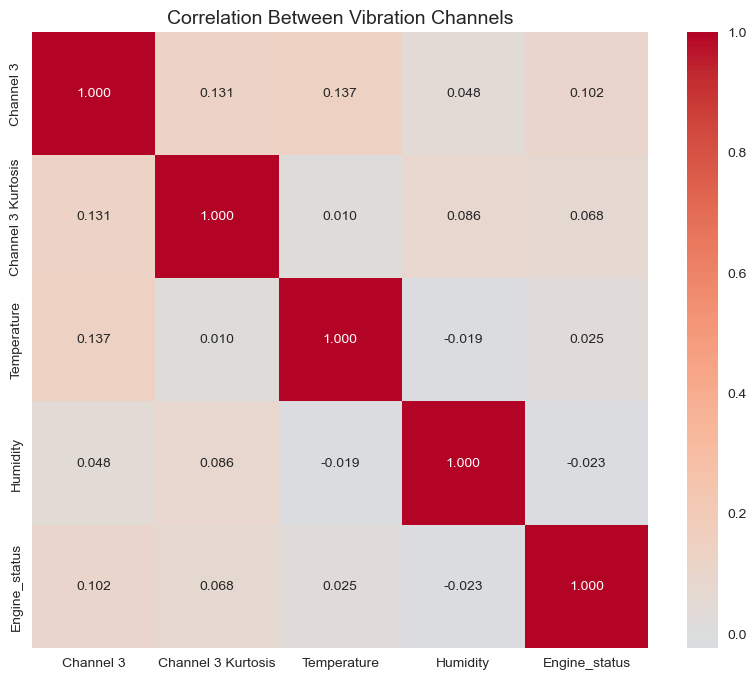

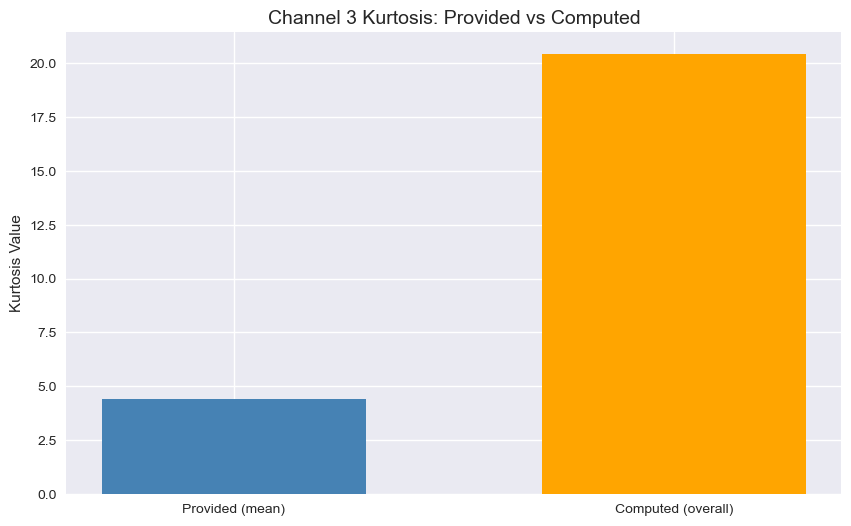

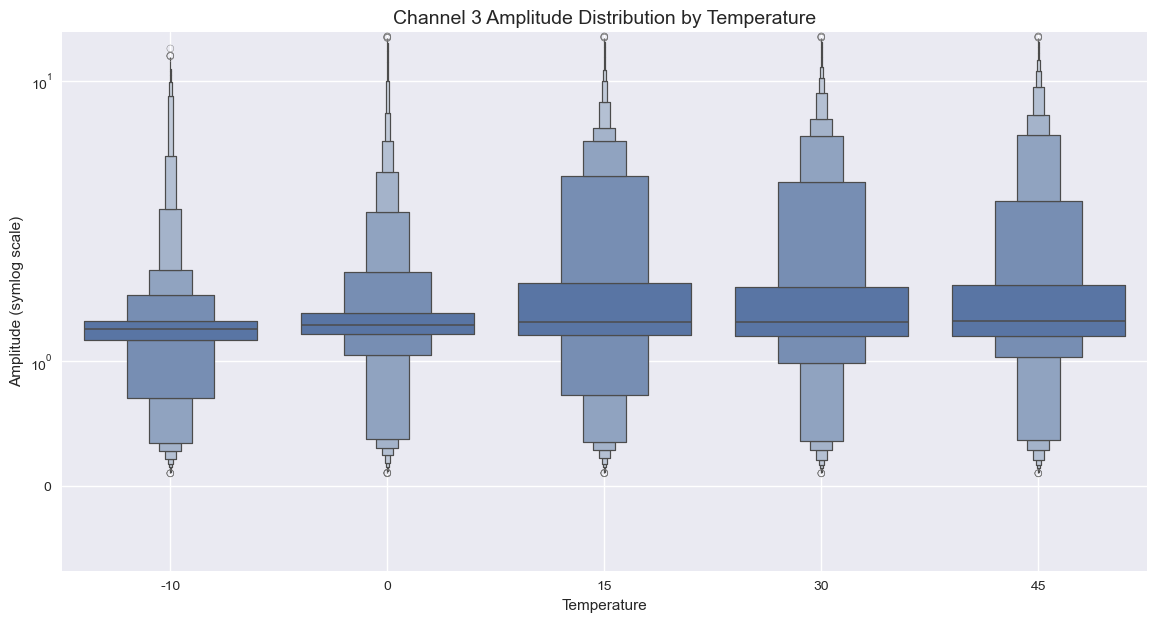

KeyboardInterrupt: 

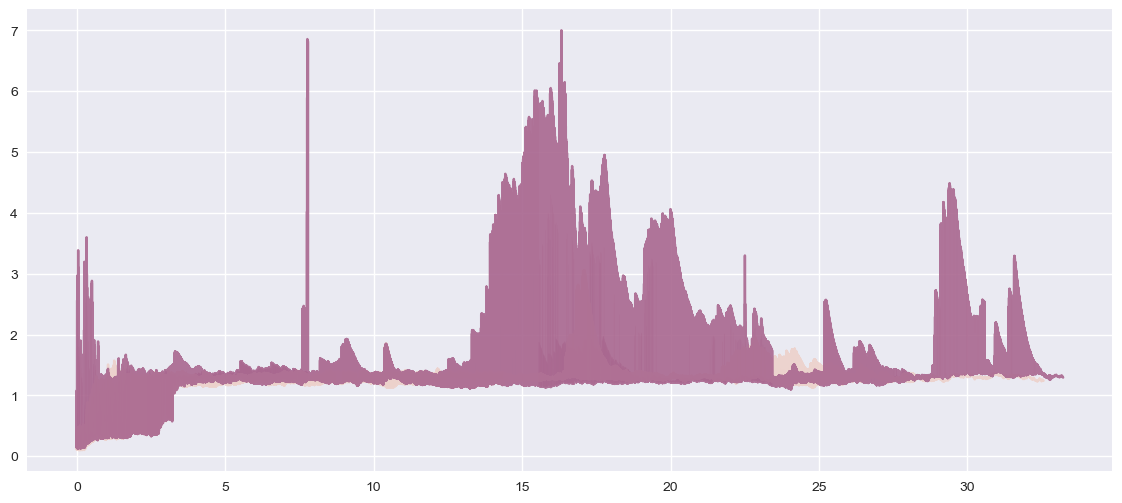

In [13]:
perform_eda_overall(Enging_df)

<Figure size 1400x600 with 0 Axes>

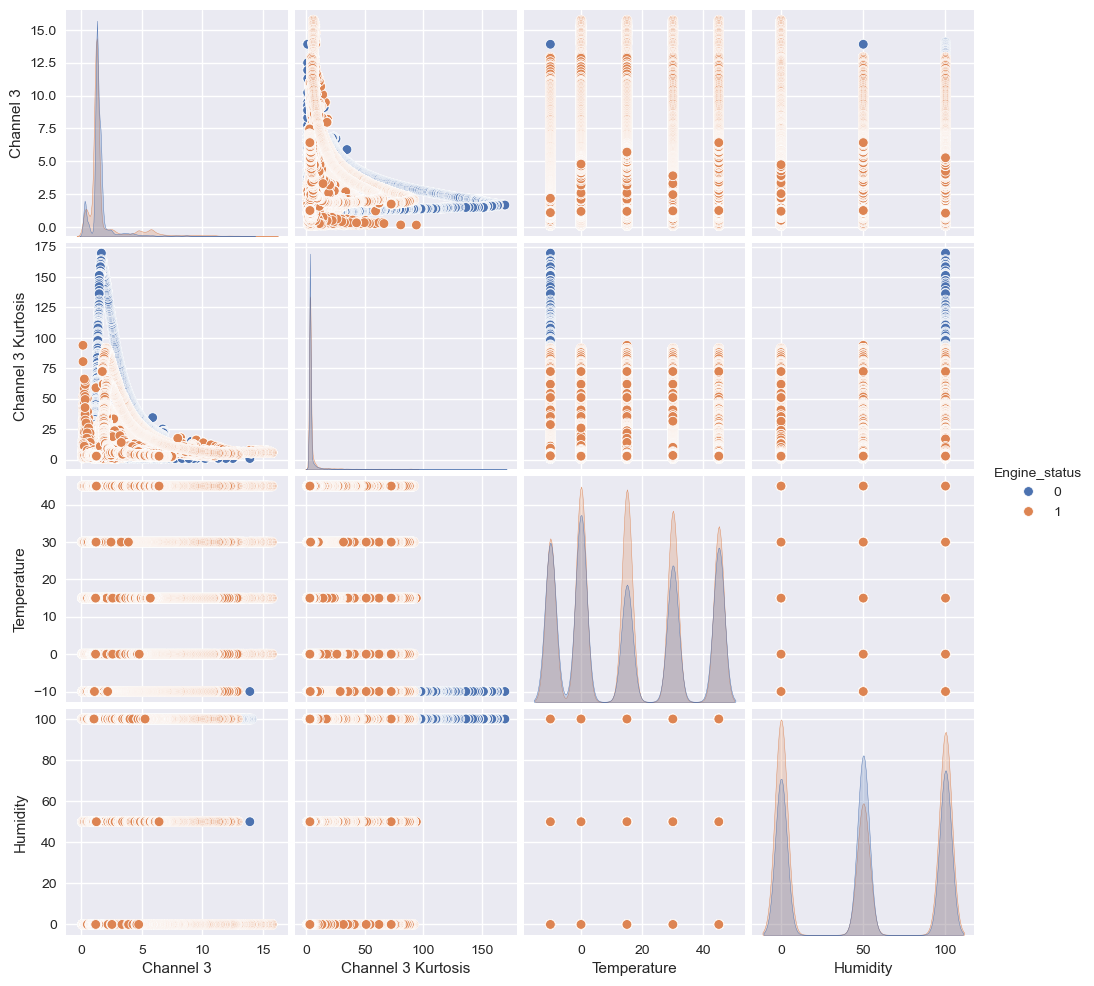

In [16]:
vibration_channels = ['Channel 3','Channel 3 Kurtosis', 'Temperature' ,'Humidity' ,'Engine_status']

plt.figure(figsize=(14, 6))
sns.pairplot(Enging_df[vibration_channels], hue="Engine_status", diag_kind="kde")
plt.show()